# Results and Evaluation

In [43]:

from pathlib import Path
import json
import sys
import re

import matplotlib.pyplot as plt
import pandas as pd

# Compact font settings to minimize overflow
plt.rcParams.update({
    'axes.titlesize': 9,
    'axes.titleweight': 'bold',
    'axes.labelsize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
})

sys.path.insert(0, 'src')

BASE = Path('examples/run_outputs')


def iter_entries(path: Path):
    data = json.loads(path.read_text())
    if isinstance(data, list):
        for item in data:
            yield item
    else:
        yield data


def parse_score(score_str: str):
    metrics = {'Completeness': None, 'Conciseness': None, 'Readability': None}
    if not score_str:
        return metrics | {'Average': None}
    parts = re.split(r',\s*', str(score_str))
    for part in parts:
        if ':' in part:
            name, val = part.split(':', 1)
            name = name.strip()
            try:
                metrics[name] = float(val.strip())
            except ValueError:
                metrics[name] = None
    vals = [v for v in metrics.values() if v is not None]
    avg = sum(vals) / len(vals) if vals else None
    metrics['Average'] = avg
    return metrics


def load_results() -> pd.DataFrame:
    rows = []
    for path in BASE.glob('*_results.json'):
        if path.name == 'combined_results.json':
            continue  # avoid double counting
        for data in iter_entries(path):
            dataset = data['dataset']
            for model_name, model_data in data['models'].items():
                detailed = model_data['metrics']['detailed']
                redundancy = model_data['metrics']['redundancy']
                gen = parse_score(model_data.get('general_score'))
                sea = parse_score(model_data.get('search_score'))
                rows.append({
                    'dataset': dataset,
                    'model': model_name,
                    'BERT F1': detailed.get('f1'),
                    'ROUGE-1': detailed.get('ROUGE-1:'),
                    'ROUGE-2': detailed.get('ROUGE-2:'),
                    'ROUGE-L': detailed.get('ROUGE-L:'),
                    'BLEU': detailed.get('BLEU'),
                    'Repeated Fact Rate': redundancy.get('repeated_fact_rate'),
                    'Bigram Redundancy': redundancy.get('bigram_redundancy'),
                    'Avg Sentence Length': redundancy.get('avg_sentence_length'),
                    'Unique Fact Ratio': redundancy.get('unique_fact_ratio'),
                    'Word Count': redundancy.get('word_count'),
                    'General Score': model_data.get('general_score'),
                    'Search Score': model_data.get('search_score'),
                    'General Completeness': gen['Completeness'],
                    'General Conciseness': gen['Conciseness'],
                    'General Readability': gen['Readability'],
                    'General Average': gen['Average'],
                    'Search Completeness': sea['Completeness'],
                    'Search Conciseness': sea['Conciseness'],
                    'Search Readability': sea['Readability'],
                    'Search Average': sea['Average'],
                })
    return pd.DataFrame(rows)


def label_bars(ax, fmt='{:.3f}'):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(fmt.format(height), (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=7, rotation=0)


df = load_results().set_index(['dataset', 'model'])
df.round(4)


BERT F1  ROUGE-1  ROUGE-2  ROUGE-L    BLEU  \
dataset model                                                   
clark   ExtendDDG   0.5832   0.1294   0.0402   0.1095  0.0029   
        AutoDDG     0.5906   0.1458   0.0421   0.1042  0.0029   
rls     ExtendDDG   0.5017   0.1509   0.0381   0.0849  0.0038   
        AutoDDG     0.4936   0.1188   0.0300   0.1089  0.0039   

                   Repeated Fact Rate  Bigram Redundancy  Avg Sentence Length  \
dataset model                                                                   
clark   ExtendDDG                 0.0             0.1027              20.6667   
        AutoDDG                   0.0             0.1017              22.2500   
rls     ExtendDDG                 0.0             0.0994              26.0000   
        AutoDDG                   0.0             0.1279              21.6250   

                   Unique Fact Ratio  Word Count  \
dataset model                                      
clark   ExtendDDG                1.0         182   
        AutoDDG                  1.0         174   
rls     ExtendDDG                1.0         180   
        AutoDDG                  1.0         172   

                                                     General Score  \
dataset model                                                        
clark   ExtendDDG  Completeness: 8, Conciseness: 9, Readability: 9   
        AutoDDG    Completeness: 8, Conciseness: 9, Readability: 9   
rls     ExtendDDG  Completeness: 6, Conciseness: 8, Readability: 8   
        AutoDDG    Completeness: 7, Conciseness: 8, Readability: 8   

                                                      Search Score  \
dataset model                                                        
clark   ExtendDDG  Completeness: 9, Conciseness: 8, Readability: 9   
        AutoDDG    Completeness: 9, Conciseness: 8, Readability: 9   
rls     ExtendDDG  Completeness: 9, Conciseness: 8, Readability: 9   
        AutoDDG    Completeness: 9, Conciseness: 8, Readability: 9   

                   General Completeness  General Conciseness  \
dataset model                                                  
clark   ExtendDDG                   8.0                  9.0   
        AutoDDG                     8.0                  9.0   
rls     ExtendDDG                   6.0                  8.0   
        AutoDDG                     7.0                  8.0   

                   General Readability  General Average  Search Completeness  \
dataset model                                                                  
clark   ExtendDDG                  9.0           8.6667                  9.0   
        AutoDDG                    9.0           8.6667                  9.0   
rls     ExtendDDG                  8.0           7.3333                  9.0   
        AutoDDG                    8.0           7.6667                  9.0   

                   Search Conciseness  Search Readability  Search Average  
dataset model                                                              
clark   ExtendDDG                 8.0                 9.0          8.6667  
        AutoDDG                   8.0                 9.0          8.6667  
rls     ExtendDDG                 8.0                 9.0          8.6667  
        AutoDDG                   8.0                 9.0          8.6667

In [44]:
df

BERT F1   ROUGE-1   ROUGE-2   ROUGE-L      BLEU  \
dataset model                                                         
clark   ExtendDDG  0.583190  0.129353  0.040201  0.109453  0.002946   
        AutoDDG    0.590551  0.145833  0.042105  0.104167  0.002869   
rls     ExtendDDG  0.501723  0.150943  0.038095  0.084906  0.003837   
        AutoDDG    0.493626  0.118812  0.030000  0.108911  0.003922   

                   Repeated Fact Rate  Bigram Redundancy  Avg Sentence Length  \
dataset model                                                                   
clark   ExtendDDG                 0.0           0.102703            20.666667   
        AutoDDG                   0.0           0.101695            22.250000   
rls     ExtendDDG                 0.0           0.099448            26.000000   
        AutoDDG                   0.0           0.127907            21.625000   

                   Unique Fact Ratio  Word Count  \
dataset model                                      
clark   ExtendDDG                1.0         182   
        AutoDDG                  1.0         174   
rls     ExtendDDG                1.0         180   
        AutoDDG                  1.0         172   

                                                     General Score  \
dataset model                                                        
clark   ExtendDDG  Completeness: 8, Conciseness: 9, Readability: 9   
        AutoDDG    Completeness: 8, Conciseness: 9, Readability: 9   
rls     ExtendDDG  Completeness: 6, Conciseness: 8, Readability: 8   
        AutoDDG    Completeness: 7, Conciseness: 8, Readability: 8   

                                                      Search Score  \
dataset model                                                        
clark   ExtendDDG  Completeness: 9, Conciseness: 8, Readability: 9   
        AutoDDG    Completeness: 9, Conciseness: 8, Readability: 9   
rls     ExtendDDG  Completeness: 9, Conciseness: 8, Readability: 9   
        AutoDDG    Completeness: 9, Conciseness: 8, Readability: 9   

                   General Completeness  General Conciseness  \
dataset model                                                  
clark   ExtendDDG                   8.0                  9.0   
        AutoDDG                     8.0                  9.0   
rls     ExtendDDG                   6.0                  8.0   
        AutoDDG                     7.0                  8.0   

                   General Readability  General Average  Search Completeness  \
dataset model                                                                  
clark   ExtendDDG                  9.0         8.666667                  9.0   
        AutoDDG                    9.0         8.666667                  9.0   
rls     ExtendDDG                  8.0         7.333333                  9.0   
        AutoDDG                    8.0         7.666667                  9.0   

                   Search Conciseness  Search Readability  Search Average  
dataset model                                                              
clark   ExtendDDG                 8.0                 9.0        8.666667  
        AutoDDG                   8.0                 9.0        8.666667  
rls     ExtendDDG                 8.0                 9.0        8.666667  
        AutoDDG                   8.0                 9.0        8.666667

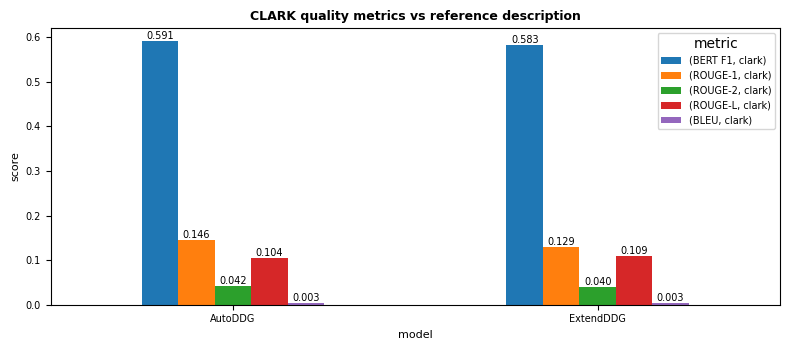

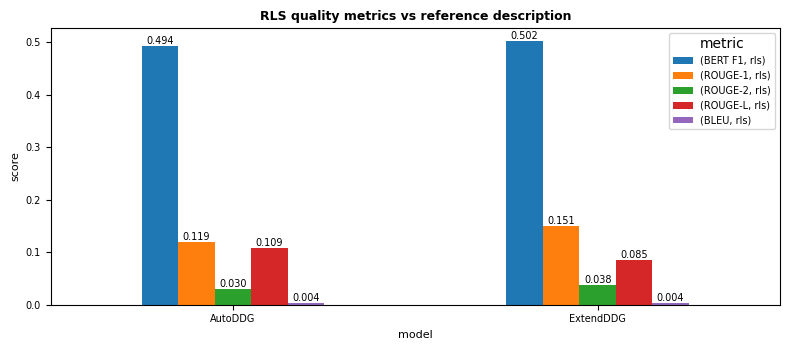

In [45]:

score_cols = ['BERT F1', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
for dataset, sub in df.groupby(level=0):
    ax = sub[score_cols].unstack(0).plot(kind='bar', figsize=(8, 3.6), rot=0)
    ax.set_ylabel('score')
    ax.set_title(f'{dataset.upper()} quality metrics vs reference description')
    ax.legend(title='metric')
    label_bars(ax)
    plt.tight_layout()
    plt.show()


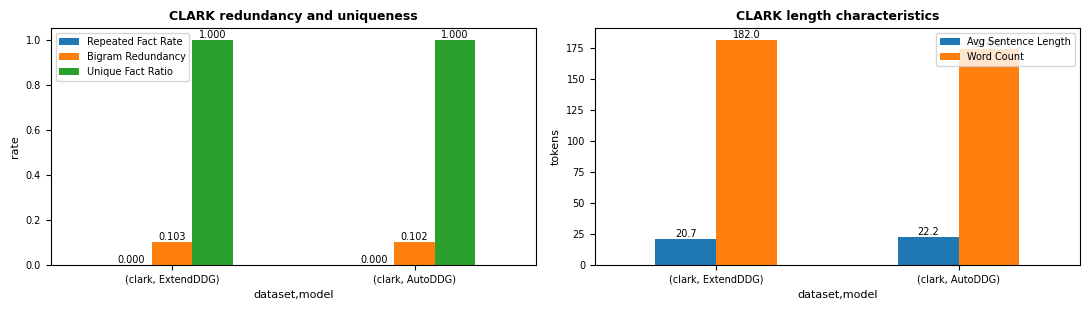

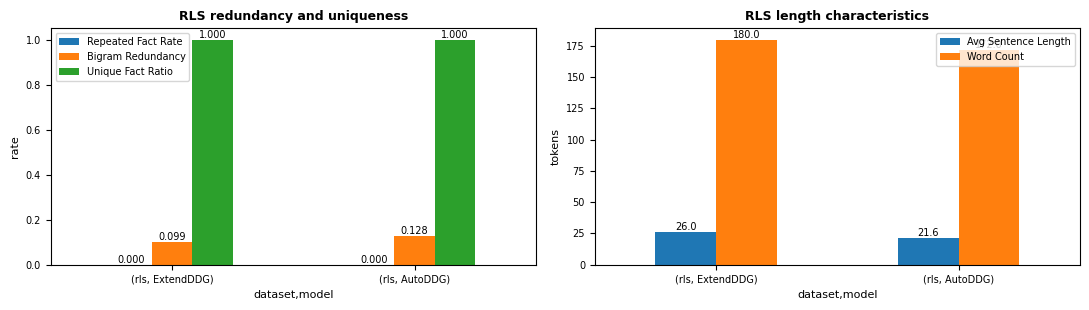

In [46]:

for dataset, sub in df.groupby(level=0):
    fig, axes = plt.subplots(1, 2, figsize=(11, 3.2))

    sub[['Repeated Fact Rate', 'Bigram Redundancy', 'Unique Fact Ratio']].plot(
        kind='bar', ax=axes[0], rot=0, title=f'{dataset.upper()} redundancy and uniqueness'
    )
    axes[0].set_ylabel('rate')
    label_bars(axes[0])

    sub[['Avg Sentence Length', 'Word Count']].plot(
        kind='bar', ax=axes[1], rot=0, title=f'{dataset.upper()} length characteristics'
    )
    axes[1].set_ylabel('tokens')
    label_bars(axes[1], fmt='{:.1f}')

    plt.tight_layout()
    plt.show()


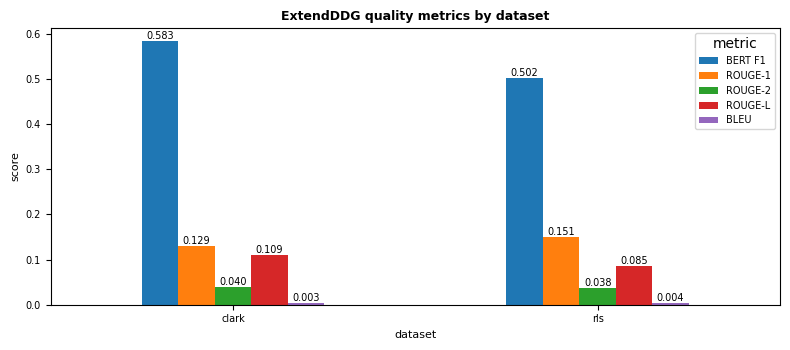

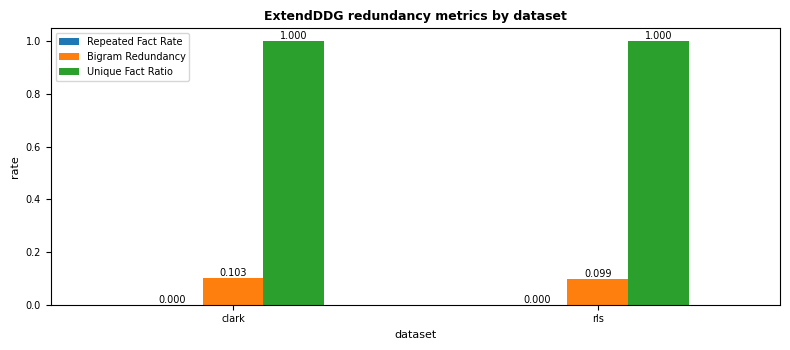

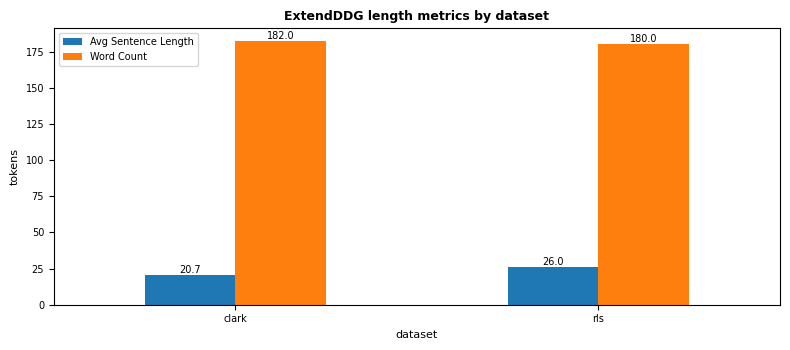

In [47]:

extend_only = df.xs('ExtendDDG', level='model')

score_cols = ['BERT F1', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
ax = extend_only[score_cols].plot(kind='bar', figsize=(8, 3.6), rot=0)
ax.set_ylabel('score')
ax.set_title('ExtendDDG quality metrics by dataset')
ax.legend(title='metric')
label_bars(ax)
plt.tight_layout()
plt.show()

red_cols = ['Repeated Fact Rate', 'Bigram Redundancy', 'Unique Fact Ratio']
ax = extend_only[red_cols].plot(kind='bar', figsize=(8, 3.6), rot=0)
ax.set_ylabel('rate')
ax.set_title('ExtendDDG redundancy metrics by dataset')
label_bars(ax)
plt.tight_layout()
plt.show()

len_cols = ['Avg Sentence Length', 'Word Count']
ax = extend_only[len_cols].plot(kind='bar', figsize=(8, 3.6), rot=0)
ax.set_ylabel('tokens')
ax.set_title('ExtendDDG length metrics by dataset')
label_bars(ax, fmt='{:.1f}')
plt.tight_layout()
plt.show()


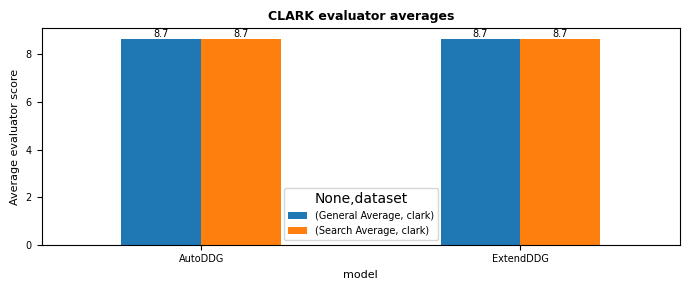

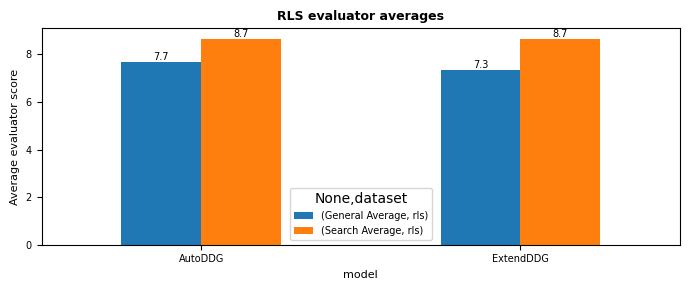

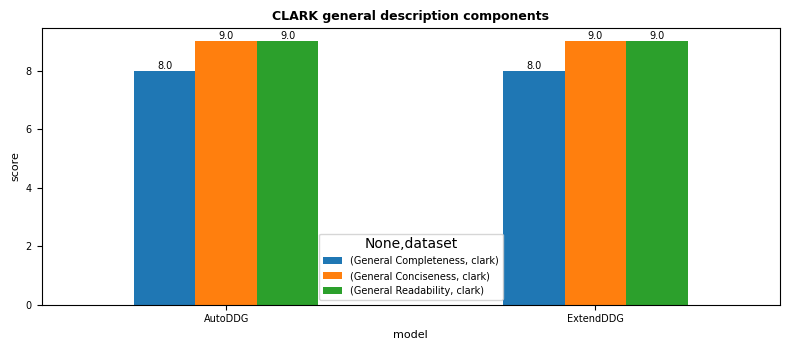

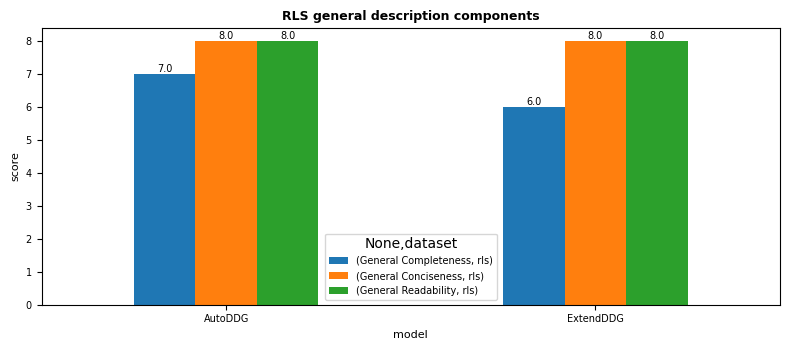

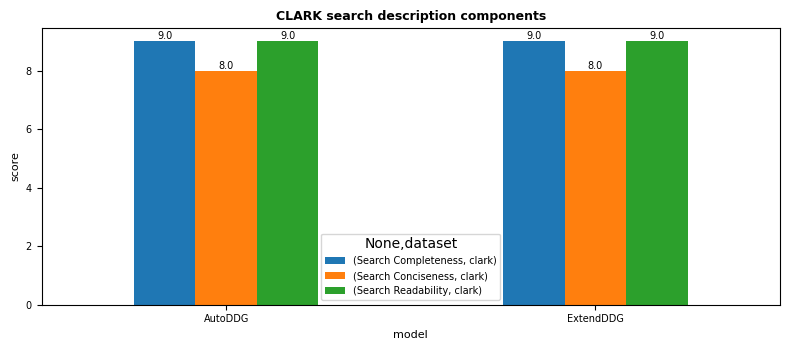

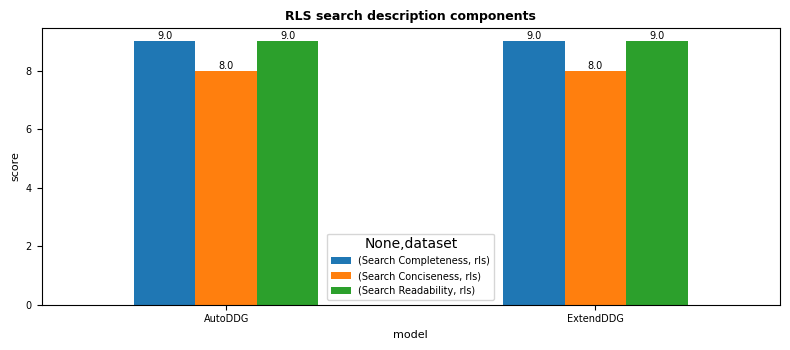

In [48]:

score_cols = ['General Average', 'Search Average']
for dataset, sub in df.groupby(level=0):
    ax = sub[score_cols].unstack(0).plot(kind='bar', figsize=(7, 3.0), rot=0)
    ax.set_ylabel('Average evaluator score')
    ax.set_title(f'{dataset.upper()} evaluator averages')
    label_bars(ax, fmt='{:.1f}')
    plt.tight_layout()
    plt.show()

for dataset, sub in df.groupby(level=0):
    comp_cols = ['General Completeness', 'General Conciseness', 'General Readability']
    ax = sub[comp_cols].unstack(0).plot(kind='bar', figsize=(8, 3.6), rot=0)
    ax.set_ylabel('score')
    ax.set_title(f'{dataset.upper()} general description components')
    label_bars(ax, fmt='{:.1f}')
    plt.tight_layout()
    plt.show()

for dataset, sub in df.groupby(level=0):
    comp_cols = ['Search Completeness', 'Search Conciseness', 'Search Readability']
    ax = sub[comp_cols].unstack(0).plot(kind='bar', figsize=(8, 3.6), rot=0)
    ax.set_ylabel('score')
    ax.set_title(f'{dataset.upper()} search description components')
    label_bars(ax, fmt='{:.1f}')
    plt.tight_layout()
    plt.show()


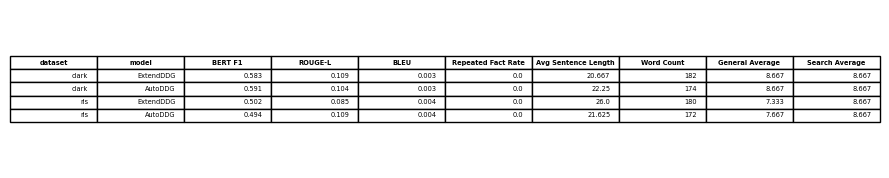

In [54]:

compact_cols = [
    'BERT F1', 'ROUGE-L', 'BLEU',
    'Repeated Fact Rate', 'Avg Sentence Length', 'Word Count',
    'General Average', 'Search Average'
]
compact = df[compact_cols].reset_index()
compact_display = compact.round(3)
compact_display

fig, ax = plt.subplots(figsize=(9, 1.0 + 0.22 * len(compact_display)))
ax.axis('off')
table = ax.table(
    cellText=compact_display.values,
    colLabels=compact_display.columns,
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(4.8)
# Bold column headers
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')

# Slight vertical compression
for key, cell in table.get_celld().items():
    cell.set_height(cell.get_height() * 0.8)

table.scale(1, 0.9)
plt.tight_layout()
plt.show()
